In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from pathlib import Path

In [242]:
usb_file = Path('recorded_data') / 'lab3_task1c.csv'
df = pl.read_csv(usb_file, separator ='\t')

In [243]:
print(df.columns)
df

['Time (ms)', 'Ch1 V', 'Ch2 V', 'Ch1 A', 'Ch2 A', 'RPM', 'Torque']


Time (ms),Ch1 V,Ch2 V,Ch1 A,Ch2 A,RPM,Torque
f64,f64,f64,f64,f64,f64,f64
0.0,41.754,-0.006,1.106,0.003,1597.924,-0.012
0.063,41.784,0.0,1.114,0.003,1611.327,-0.014
0.125,41.76,0.0,1.147,-0.006,1593.05,-0.014
0.188,41.589,0.0,1.18,0.003,1612.546,-0.014
0.25,41.364,0.0,1.163,0.003,1601.58,-0.015
…,…,…,…,…,…,…
1999.286,0.0,0.0,0.0,-0.006,0.492,-0.009
1999.348,0.0,0.0,0.0,0.011,-0.726,-0.009
1999.411,0.0,0.0,0.0,0.003,1.711,-0.009


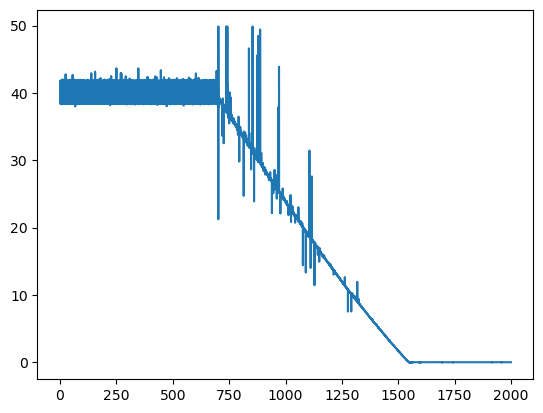

In [244]:
voltage = df['Ch1 V']
time = df['Time (ms)']

plt.plot(time, voltage)

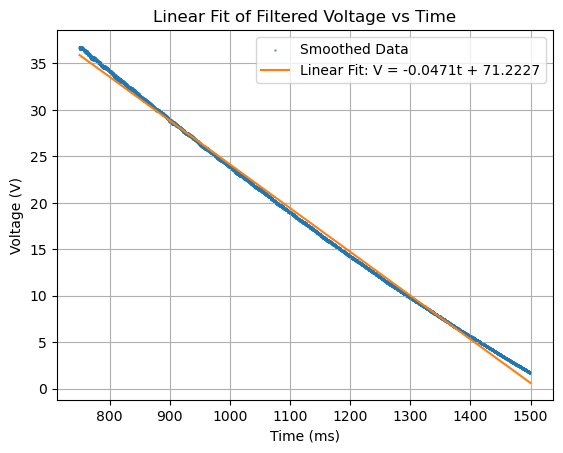

In [245]:
start_index = np.searchsorted(time, 750)
end_index = np.searchsorted(time, 1500)
# Trim data to focus only on the relevant part
filtered_time = time[start_index:end_index]
filtered_voltage = voltage[start_index:end_index]
from scipy.signal import medfilt

smoothed_voltage = medfilt(filtered_voltage, kernel_size=5)
plt.plot(filtered_time, smoothed_voltage)

slope, intercept = np.polyfit(filtered_time, smoothed_voltage, 1)

fitted_voltage = slope*filtered_time + intercept

plt.scatter(filtered_time, smoothed_voltage, label="Smoothed Data", alpha = 0.7, s=0.5)
plt.plot(filtered_time, fitted_voltage, label=f"Linear Fit: V = {slope:.4f}t + {intercept:.4f}")

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.title("Linear Fit of Filtered Voltage vs Time")
plt.legend()
plt.grid()
plt.show()

In [246]:
import json

# Load JSON file
with open("output/model_results.json", "r") as f:
    results = json.load(f)

# Extract values
linear_coef = results["linear_coef"]
linear_intercept = results["linear_intercept"]
quadratic_coef = results["quadratic_coef"]
quadratic_intercept = results["quadratic_intercept"]

# Print or use them
print(f"Linear Model: Coef = {linear_coef}, Intercept = {linear_intercept}")
print(f"Quadratic Model: Coef = {quadratic_coef}, Intercept = {quadratic_intercept}")

Linear Model: Coef = [4.70677675477113e-05], Intercept = 0.1749479564789396
Quadratic Model: Coef = [0.0, 0.0001404151859556228, -5.0672102558525735e-08], Intercept = 0.14374596496357064


In [247]:
analyzed_portion = df[start_index:end_index]
# Define k_t (replace with actual value)
k_t = 0.231

# Quadratic model coefficients from previous regression
a_quad = quadratic_coef[2]  # Coefficient for n^2
b_quad = quadratic_coef[1]  # Coefficient for n
c_quad = quadratic_intercept  # Intercept term
analyzed_portion.head()

analyzed_portion = analyzed_portion.with_columns(
    (a_quad * pl.col("RPM") ** 2 + b_quad * pl.col("RPM") + c_quad).alias("Torque_fric")
    ).with_columns(
        (pl.col("Torque_fric") * k_t / -slope).alias("J_rotor")
    )

j_array = analyzed_portion["J_rotor"].to_numpy()
j_mean = np.mean(j_array)
print(j_mean)

1.0379056315816677


[-2.48623855e-07  6.88950389e-04  7.05292934e-01]


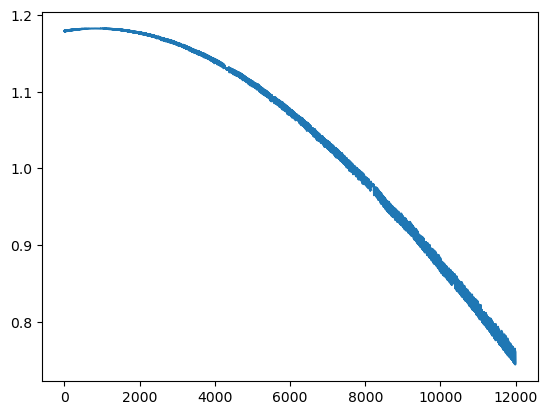

In [248]:
plt.plot(analyzed_portion["J_rotor"])

coeff = np.polyfit(analyzed_portion["RPM"], j_array, 2)
print(coeff)

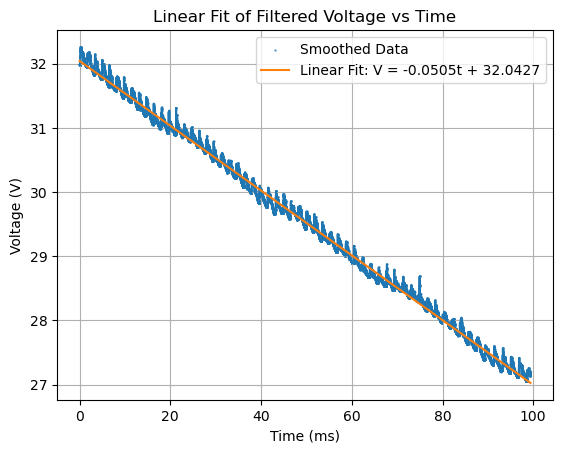

In [249]:
usb_file = Path('recorded_data') / 'task1_gr'
df = pl.read_csv(usb_file, separator ='\t')
voltage = df['Ch1 V']
time = df['Time (ms)']

# Trim data to focus only on the relevant part
filtered_time = time
filtered_voltage = voltage
smoothed_voltage = medfilt(filtered_voltage, kernel_size=5)
plt.plot(filtered_time, smoothed_voltage)

slope, intercept = np.polyfit(filtered_time, smoothed_voltage, 1)

fitted_voltage = slope*filtered_time + intercept

plt.scatter(filtered_time, smoothed_voltage, label="Smoothed Data", alpha = 0.7, s=0.5)
plt.plot(filtered_time, fitted_voltage, label=f"Linear Fit: V = {slope:.4f}t + {intercept:.4f}")

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.title("Linear Fit of Filtered Voltage vs Time")
plt.legend()
plt.grid()
plt.show()

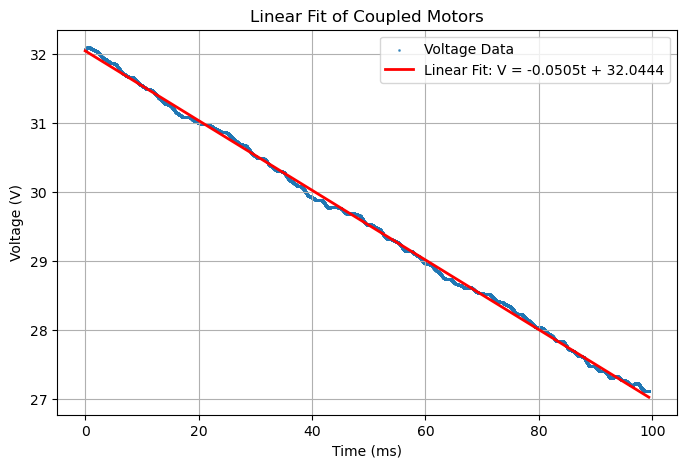

In [250]:
from scipy.signal import butter, filtfilt
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path

# Load data
usb_file = Path('recorded_data') / 'task1_gr'
df = pl.read_csv(usb_file, separator='\t')
voltage = df['Ch1 V'].to_numpy()
time = df['Time (ms)'].to_numpy()

# Define Butterworth low-pass filter
def butter_lowpass_filter(data, cutoff=2, fs=1000, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Apply the filter
smoothed_voltage = butter_lowpass_filter(voltage, cutoff=2, fs=1000, order=4)

# Linear Fit
slope, intercept = np.polyfit(time, smoothed_voltage, 1)
fitted_voltage = slope * time + intercept

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(time, smoothed_voltage, label="Voltage Data", alpha=0.7, s=1)
plt.plot(time, fitted_voltage, color='red', linewidth=2, label=f"Linear Fit: V = {slope:.4f}t + {intercept:.4f}")

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.title("Linear Fit of Coupled Motors")
plt.legend()
plt.grid()
plt.show()


In [251]:
analyzed_portion = df.filter(pl.col("Time (ms)").is_in(time))
analyzed_portion = analyzed_portion.with_columns(pl.Series('Smoothed Voltage', smoothed_voltage))
# Define k_t (replace with actual value)
k_t = 0.227

# Quadratic model coefficients from previous regression
a_quad = quadratic_coef[2]  # Coefficient for n^2
b_quad = quadratic_coef[1]  # Coefficient for n
c_quad = quadratic_intercept  # Intercept term

analyzed_portion = analyzed_portion.with_columns(
    (a_quad * pl.col("RPM") ** 2 + b_quad * pl.col("RPM") + c_quad).alias("Torque_fric")
    ).with_columns(
        (pl.col("Torque_fric") * k_t / -slope).alias("J_rotor")
    )

j_array = analyzed_portion["J_rotor"].to_numpy()
j_mean = np.mean(j_array)
print(j_mean)

1.0754095899902412


In [252]:
data = {
    "n [RPM]": [160.00, 356.00, 544.00, 731.00, 935.00, 1136.00, 1316.00, 1525.00, 1721.00],
    "Tm [Nm]": [0.25, 0.36, 0.47, 0.58, 0.70, 0.81, 0.92, 1.05, 1.15]
}

df = pl.DataFrame(data)

df.head()

n [RPM],Tm [Nm]
f64,f64
160.0,0.25
356.0,0.36
544.0,0.47
731.0,0.58
935.0,0.7


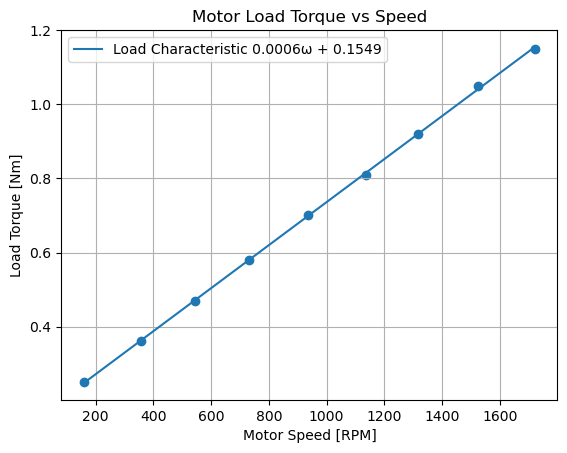

In [253]:
# Define the images folder path
images_dir = Path("images")

# Ensure the "images" folder exists
images_dir.mkdir(parents=True, exist_ok=True)

# Define the file path
file_path = images_dir / "num8.png"

x = df['n [RPM]']
y = df['Tm [Nm]']

slope, intercept = np.polyfit(x,y,1)
y_fit = slope*x + intercept

plt.scatter(df['n [RPM]'], df['Tm [Nm]'])
plt.plot(x, y_fit, label=fr"Load Characteristic {slope:.4f}ω + {intercept:.4f}")
plt.grid()
plt.xlabel("Motor Speed [RPM]")
plt.ylabel("Load Torque [Nm]")
plt.legend()
plt.title("Motor Load Torque vs Speed")
plt.savefig(file_path, dpi = 300, bbox_inches = "tight")
plt.show()

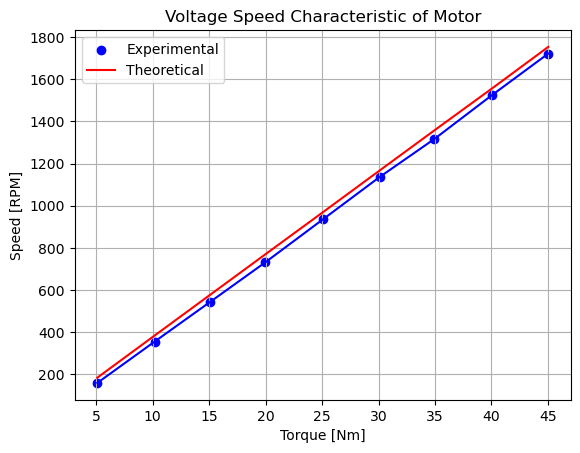

In [254]:
## 2B num 2
data = {
    "V1(ave) [V]": [5.10, 10.18, 15.09, 19.96, 25.07, 30.10, 34.94, 40.07, 45.03],
    "n [RPM]": [160.00, 356.00, 544.00, 731.00, 935.00, 1136.00, 1316.00, 1525.00, 1721.00],
    "Tm [Nm]" :	[0.25,	0.36,	0.47,	0.58,	0.70,	0.81,	0.92,	1.05,	1.15]
}

df = pl.DataFrame(data)
df.head()

k_t = 0.227
K_fric = 4.49e-4
R_a = 0.62

df = df.with_columns(
    (pl.col("V1(ave) [V]") * k_t / (k_t**2+R_a*K_fric) - R_a * pl.col("Tm [Nm]") / (k_t ** 2 + R_a * K_fric)).alias("Theoretical Speed")
    )

df = df.with_columns(
    pl.col("Theoretical Speed") * 60/(2*np.pi)
)

x = df["V1(ave) [V]"]
y1 = df["n [RPM]"]
y2 = df["Theoretical Speed"]
fig, ax = plt.subplots()
ax.plot(x, y1, c='b')
ax.scatter(x,y1, label="Experimental", c='b')
ax.set_ylabel("Speed [RPM]")
ax.set_xlabel("Torque [Nm]")

ax.plot(x, y2, label="Theoretical", c='red')
ax.grid()
ax.legend()
ax.set_title("Voltage Speed Characteristic of Motor")

save_path = Path("images") / "B_2.png"
plt.savefig(save_path)
plt.show()

In [255]:
## B_3
data = {
'V1(ave)':	[40.50,	40.09,	39.63,	39.25,	38.91	,38.60	,38.50],
'I1(ave)':	[1.93,	2.66,	3.33,	3.96,	4.52,	5.07,	5.34],
'V2(ave)':	[39.08,	37.10,	35.95,	34.60,	33.41,	32.45,	32.00],
'I2(ave)':	[0.00,	0.74,	1.43,	2.05,	2.63,	3.18	,3.45],
'n':	[1640.00,	1600.00	,1562.00	,1528.00,	1496.00,	1470.00,	1460.00],
'P2/P1':	[0.00,	0.26,	0.39,	0.46,	0.50,	0.53,	0.54]
}

df = pl.DataFrame(data)

k_t = 0.227
K_fric = 4.49e-4
R_a = 0.62

df = df.with_columns(
    (pl.col('n') * 2*np.pi/60).alias('rad/s')
).with_columns(
    (k_t * pl.col('I1(ave)') - 2*K_fric*pl.col('rad/s')).alias('Torque Theo')
).with_columns(
    (pl.col('Torque Theo') * pl.col('rad/s') / (pl.col('I1(ave)') * pl.col('V1(ave)'))).alias('eta theo')
)
df = df[1:]

Maximum Experimental Efficiency at Current = 5.41 A
Maximum Theoretical Efficiency at Current = 5.23 A


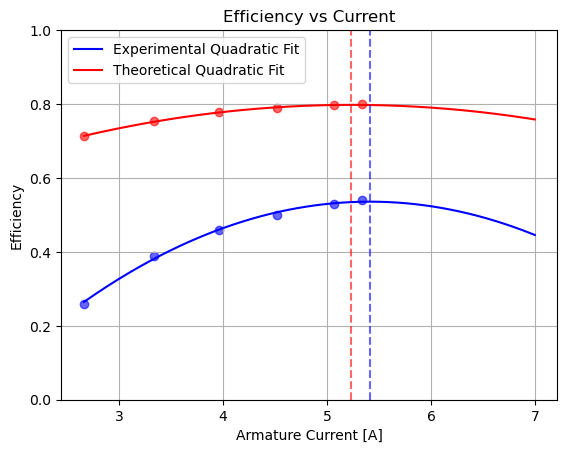

In [256]:

x = df["I1(ave)"]
y2 = df["eta theo"]
y1 = df["P2/P1"]
# Original data fits
coeff_exp = np.polyfit(x, y1, 2)
coeff_theo = np.polyfit(x, y2, 2)

# Calculate the current at maximum efficiency for both curves
I_max_exp = -coeff_exp[1] / (2 * coeff_exp[0])
I_max_theo = -coeff_theo[1] / (2 * coeff_theo[0])

print(f"Maximum Experimental Efficiency at Current = {I_max_exp:.2f} A")
print(f"Maximum Theoretical Efficiency at Current = {I_max_theo:.2f} A")

# Extend the current range up to 7 A for smooth curves
x_extended = np.linspace(min(x), 7, 200)
y1_fit_extended = np.polyval(coeff_exp, x_extended)
y2_fit_extended = np.polyval(coeff_theo, x_extended)

fig, ax = plt.subplots()

# Plot extended fitted curves
ax.plot(x_extended, y1_fit_extended, label="Experimental Quadratic Fit", c='b')
ax.scatter(x, y1, c='b', alpha=0.6)

ax.plot(x_extended, y2_fit_extended, label="Theoretical Quadratic Fit", c='red')
ax.scatter(x, y2, c='red', alpha=0.6)

# Vertical lines indicating max efficiency currents (no labels)
ax.axvline(I_max_exp, color='b', linestyle='--', alpha=0.6)
ax.axvline(I_max_theo, color='red', linestyle='--', alpha=0.6)

ax.set_ylabel("Efficiency")
ax.set_xlabel("Armature Current [A]")
ax.set_ylim(0, 1)
ax.grid()
ax.legend()
ax.set_title("Efficiency vs Current")

# Save plot
save_path = Path("images") / "B_3.png"
save_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_path)
plt.show()


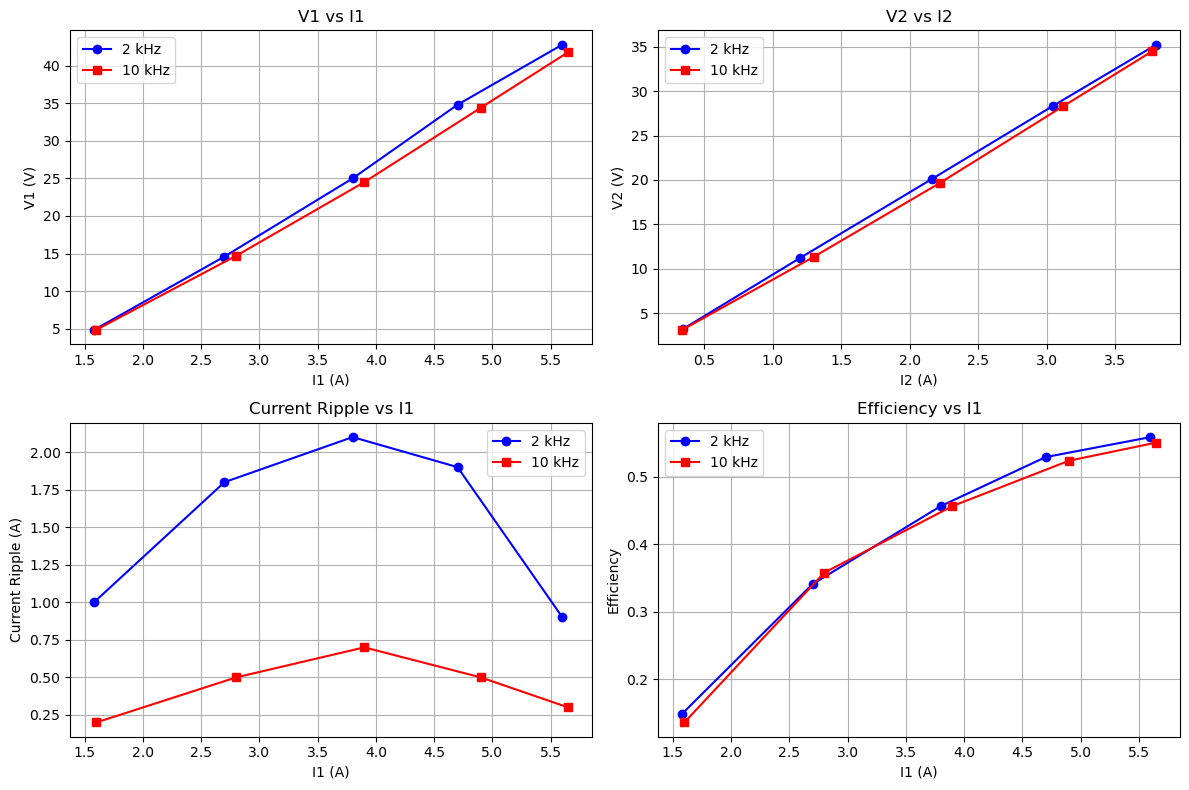

'\nObservations:\n1. The voltage-current characteristics (V1 vs I1 and V2 vs I2) for both frequencies are similar, but slight differences exist due to switching losses at different frequencies.\n2. The 10 kHz operation significantly reduces current ripple, as expected due to higher switching frequency smoothing the current waveform.\n3. The efficiency at 10 kHz appears slightly better than at 2 kHz, which could be attributed to lower ripple and better power transfer efficiency.\n4. The trade-off of using a higher switching frequency is increased switching losses, which may impact overall efficiency at very high currents.\n'

In [257]:
import numpy as np
import matplotlib.pyplot as plt

# Data for 2 kHz
V1_2kHz = np.array([4.83, 14.60, 25.00, 34.80, 42.80])
I1_2kHz = np.array([1.58, 2.70, 3.80, 4.70, 5.60])
Ripple_2kHz = np.array([1.00, 1.80, 2.10, 1.90, 0.90])
V2_2kHz = np.array([3.24, 11.20, 20.08, 28.38, 35.25])
I2_2kHz = np.array([0.35, 1.20, 2.16, 3.05, 3.80])

# Data for 10 kHz
V1_10kHz = np.array([4.85, 14.70, 24.50, 34.40, 41.80])
I1_10kHz = np.array([1.60, 2.80, 3.90, 4.90, 5.65])
Ripple_10kHz = np.array([0.20, 0.50, 0.70, 0.50, 0.30])
V2_10kHz = np.array([3.10, 11.33, 19.65, 28.30, 34.50])
I2_10kHz = np.array([0.34, 1.30, 2.22, 3.12, 3.77])

# Create separate plots for each frequency
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# V1 vs I1
axes[0, 0].plot(I1_2kHz, V1_2kHz, marker='o', label="2 kHz", color="blue")
axes[0, 0].plot(I1_10kHz, V1_10kHz, marker='s', label="10 kHz", color="red")
axes[0, 0].set_xlabel("I1 (A)")
axes[0, 0].set_ylabel("V1 (V)")
axes[0, 0].set_title("V1 vs I1")
axes[0, 0].legend()
axes[0, 0].grid()

# V2 vs I2
axes[0, 1].plot(I2_2kHz, V2_2kHz, marker='o', label="2 kHz", color="blue")
axes[0, 1].plot(I2_10kHz, V2_10kHz, marker='s', label="10 kHz", color="red")
axes[0, 1].set_xlabel("I2 (A)")
axes[0, 1].set_ylabel("V2 (V)")
axes[0, 1].set_title("V2 vs I2")
axes[0, 1].legend()
axes[0, 1].grid()

# Current Ripple vs I1
axes[1, 0].plot(I1_2kHz, Ripple_2kHz, marker='o', label="2 kHz", color="blue")
axes[1, 0].plot(I1_10kHz, Ripple_10kHz, marker='s', label="10 kHz", color="red")
axes[1, 0].set_xlabel("I1 (A)")
axes[1, 0].set_ylabel("Current Ripple (A)")
axes[1, 0].set_title("Current Ripple vs I1")
axes[1, 0].legend()
axes[1, 0].grid()

# Efficiency (V2*I2) / (V1*I1)
Efficiency_2kHz = (V2_2kHz * I2_2kHz) / (V1_2kHz * I1_2kHz)
Efficiency_10kHz = (V2_10kHz * I2_10kHz) / (V1_10kHz * I1_10kHz)

axes[1, 1].plot(I1_2kHz, Efficiency_2kHz, marker='o', label="2 kHz", color="blue")
axes[1, 1].plot(I1_10kHz, Efficiency_10kHz, marker='s', label="10 kHz", color="red")
axes[1, 1].set_xlabel("I1 (A)")
axes[1, 1].set_ylabel("Efficiency")
axes[1, 1].set_title("Efficiency vs I1")
axes[1, 1].legend()
axes[1, 1].grid()

plt.tight_layout()
plt.show()

"""
Observations:
1. The voltage-current characteristics (V1 vs I1 and V2 vs I2) for both frequencies are similar, but slight differences exist due to switching losses at different frequencies.
2. The 10 kHz operation significantly reduces current ripple, as expected due to higher switching frequency smoothing the current waveform.
3. The efficiency at 10 kHz appears slightly better than at 2 kHz, which could be attributed to lower ripple and better power transfer efficiency.
4. The trade-off of using a higher switching frequency is increased switching losses, which may impact overall efficiency at very high currents.
"""


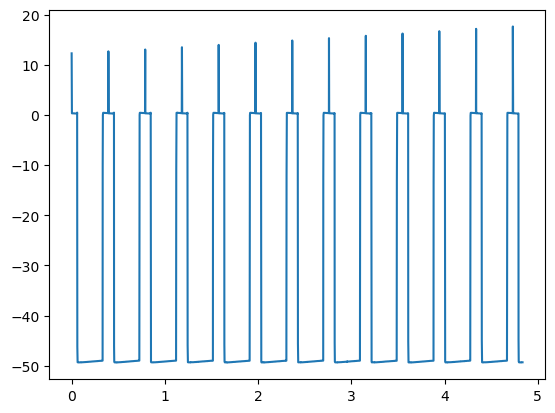

In [266]:
usb_file = Path('recorded_data') / 'task_4_0.3'
file_2 = Path('recorded_data') / 'task_4_0.9'
df = pl.read_csv(usb_file, separator ='\t')
df2 = pl.read_csv(usb_file, separator ='\t')

x = df["Time (ms)"]
y = df["Ch1 V"]

x2 = df2["Time (ms)"]
y2 = df2["Ch1 V"]

# plt.plot(x,y)
plt.plot(x2,y2)